Import the necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum
import math
import json

Section 1.0: Setup

In [184]:
class BasisFunctions(Enum):
    LINEAR = "linear"
    POLYNOMIAL = "polynomial"
    GAUSSIAN = "gaussian"
    SIGMOID = "sigmoid"

class GDMethods(Enum):
    GD = "gd"
    SGD = "sgd"
    ANALYTIC = "analytic"

class Linear_Regression:
    """
    Initializes Linear Regression model with configurable basis functions. Assumes 0 initial weights. Note that
    self.weights.shape = (num_features + 1,) due to bias being always linear.

    Args:
        X (numpy.ndarray): list of base, linear features (Nx1)
        y (numpy.ndarray): Targets (Nx1)
        basis_function (BasisFunctions): basis function that gets applied to each feature.
        num_features (int): number of features (if 0, will only have bias)
    """
    def __init__(self, X, y, num_features, basis_function: BasisFunctions):
        self.basis_function = basis_function
        self.num_features = num_features
        self.weights = np.zeros(self.num_features + 1)
        self.X = self.transform_X(X)
        self.y = y
    
    """
    Will transform the X design matrix into a transformed design matrix (capital Phi) by applying the corresponding basis function.
    Returns an N x (num_features + 1) design matrix where the (num_features) rightmost columns have the basis function applied.
    """
    def transform_X(self, X):
        X = X.reshape(-1, 1)
        N = X.shape[0]

        temp = np.ones((N, 1)).reshape(-1, 1)
        match self.basis_function:
            case BasisFunctions.LINEAR: 
                for i in range (1, self.num_features + 1):
                    temp = np.hstack((temp, X))
            case BasisFunctions.POLYNOMIAL:
                for i in range (1, self.num_features + 1):
                    temp = np.hstack((temp, X ** i))
            case BasisFunctions.GAUSSIAN:
                X_max = np.max(X)
                X_min = np.min(X)
                for i in range (1, self.num_features + 1):
                    mean = X_min + (X_max - X_min) * (i - 1) / (self.num_features - 1)
                    exponent = -((X - mean)**2)
                    gaussian = np.exp(exponent)
                    temp = np.hstack((temp, gaussian))
            case BasisFunctions.SIGMOID:
                X_max = np.max(X)
                X_min = np.min(X)
                for i in range (1, self.num_features + 1):
                    mean = X_min + (X_max - X_min) * (i - 1) / (self.num_features - 1)
                    exponent = -(X - mean)
                    sigmoid = 1 / (1 + np.exp(exponent))
                    temp = np.hstack((temp, sigmoid))
        return temp    

    def reset_model(self):
        self.weights = np.zeros(self.num_features + 1)
    
    def plot_bases(self):
        pass

    def plot_model(self, X_data, y_data, show_bases=True, show_true_function=False, **kwargs):
        w = np.asarray(self.weights).reshape(-1)

        x_dense = np.linspace(X_data.min(), X_data.max(), 1000)

        Phi_dense = self.transform_X(x_dense)
        y_hat = Phi_dense @ w

        plt.figure(figsize=(8, 4.5))
        plt.scatter(X_data, y_data, s=18, alpha=0.75, label="data", color="blue")

        if show_bases:
            # Plot each weighted basis (skip bias column 0)
            for j in range(Phi_dense.shape[1]):
                plt.plot(x_dense, w[j] * Phi_dense[:, j], linewidth=0.8, alpha=0.4)

        if show_true_function and kwargs.get("true_function"):
            true_function = kwargs.get("true_function")
            plt.plot(x_dense, true_function(x_dense), alpha=0.75, label="true function", color="green")

        plt.plot(x_dense, y_hat, linewidth=2.5, label="model", color="red")
        plt.ylim(bottom=np.min(self.y) - 0.5, top=np.max(self.y) + 0.5)
        plt.title(kwargs.get("title") if not None else f"Linear Regression with {self.basis_function.value.capitalize()} bases")
        plt.legend()
        plt.tight_layout()
        plt.show()

    """
    Fits the linear regression model depending on GD method. Different arguments are required depending on method.
    kwargs contains: "epoch", "learning_rate", "print_vals", "regularization_strength", { "regularization": "L1", "L2" }, "output_err", "output_weights"
    and if "output_err", will return { "train_errs": list[float] }
    and if "output_weights", will return { "weights": list[float] }
    """
    def fit(self, method: GDMethods, **kwargs):
        do_print_vals = kwargs.get("print_vals")
        regularization_strength = kwargs.get("regularization_strength")
        regularization = kwargs.get("regularization")
        train_errors = []
        weights = []
        if regularization_strength is None:
            regularization_strength = 0
        match method:
            case GDMethods.ANALYTIC:
                if regularization is not None and regularization == "L2":
                    self.weights = np.linalg.pinv(self.X.T @ self.X + regularization_strength * np.eye(self.X.shape[1] + 1)) @ self.X.T @ self.y
                else:
                    self.weights = np.linalg.pinv(self.X.T @ self.X) @ self.X.T @ self.y
            case GDMethods.SGD:
                lr = float(kwargs.get("learning_rate"))
                for epoch in range(1, int(kwargs.get("epoch")) + 1):
                    epoch_loss = np.sum((self.X @ self.weights - self.y)**2) / self.X.shape[0]
                    if do_print_vals is not None and do_print_vals:
                        print(f"Epoch {epoch - 1} SSE: {epoch_loss}")
                    train_errors.append(epoch_loss)

                    weights.append(self.weights.copy())
                    for (x, y) in zip(self.X, self.y):
                        grad = x * (self.weights.T @ x - y)
                        if regularization is not None and regularization == "L1":
                            self.weights -= lr * grad / grad.shape[0]
                            self.weights[1:] -= lr * (regularization_strength * np.sign(self.weights[1:]))
                        if regularization is not None and regularization == "L2":
                            self.weights -= lr * grad / grad.shape[0]
                            self.weights[1:] -= lr * (regularization_strength * self.weights[1:])
                        else: 
                            self.weights -= lr * grad / grad.shape[0]

                final_loss = np.sum((self.X @ self.weights - self.y)**2) / self.X.shape[0]
                if do_print_vals is not None and do_print_vals:
                    print(f"Final SSE: {final_loss}")
            case GDMethods.GD:
                lr = float(kwargs.get("learning_rate"))
                for epoch in range(1, int(kwargs.get("epoch")) + 1):
                    weights.append(self.weights.copy())
                    epoch_loss = np.sum((self.X @ self.weights - self.y)**2)
                    if do_print_vals is not None and do_print_vals:
                        print(f"Epoch {epoch - 1} SSE: {epoch_loss}")
                    
                    train_errors.append(epoch_loss)
                    grad = self.X.T @ (self.X @ self.weights - self.y)
                    if regularization is not None and regularization == "L1":
                        self.weights -= lr * grad / grad.shape[0]
                        self.weights[1:] -= lr * (regularization_strength * np.sign(self.weights[1:]))
                    if regularization is not None and regularization == "L2":
                        self.weights -= lr * grad / grad.shape[0]
                        self.weights[1:] -= lr * (regularization_strength * self.weights[1:])
                    else: 
                        self.weights -= lr * grad / grad.shape[0]                
                final_loss = np.sum((self.X @ self.weights - self.y)**2) / self.X.shape[0]
                if do_print_vals is not None and do_print_vals:
                    print(f"Final SSE: {final_loss}")
        
        output_err = kwargs.get("output_err")
        output_weights = kwargs.get("output_weights")
        if output_err:
            return { "train_errs": train_errors }
        elif output_weights:
            return { "weights": weights }

    """
    Samples one value from a given function while adding Gaussian noise.

    Args:
        x (float): Input to function
        function (Callable(float, float)): Function to be sampled from.
        std (float): Standard deviation
        seed (int): Defaulted to None, but used for consistent sampling
    
    Returns:
        float: Sampled value from function
    """
    @staticmethod
    def gaussian_noise_sampling(x, function, std=1, seed=None, section_4=False):
        gaussian_sample = np.random.default_rng(seed=seed).normal(loc=0, scale=std, size=1)
        if not section_4:
            return function(x) + gaussian_sample
        else:
            return function(x) + 2 * gaussian_sample

    @staticmethod
    def sampler(function, sample_size, x_start, x_end, std=1, seed=None, random=False, section_4=False):
        if random:
            x_values = np.random.default_rng().uniform(low=x_start, high=x_end, size=sample_size)
        else:
            x_values = np.linspace(x_start, x_end, sample_size)
        
        y_values = []
        for i in range(sample_size):
            y_values.append(Linear_Regression.gaussian_noise_sampling(x_values[i], function, std, seed, section_4=True if section_4 else False)[0])
        
        y_values = np.array(y_values)

        return {"x": x_values, "y": y_values}
    
    @staticmethod
    def assignment_function(x):
        return (np.log(x) + 1) * np.cos(x) + np.sin(2 * x)

    @staticmethod
    def assignment_function_section_4(x):
        return -3 * x + 8
    
    # Will use entire dataset to split into folds. (No need for test subset)
    # This CV is for the number of features
    @staticmethod
    def cross_validation_10_fold(X, y):
        X_folds = np.array_split(X, 10)
        y_folds = np.array_split(y, 10)

        # { train_err: float, std: float }
        train_results = {}
        # { val_err: float, std: float}
        val_results = {}

        # 10 diff hyperparam (#features) values (0, 5, ..., 40, 45)
        for i in range(10):
            
            # the actual 10-fold CV for one hyperparam value
            temp_train_err = []
            temp_val_err = []
            for j in range(10):
                training_X = np.hstack([X_folds[k] for k in range(10) if k != j])
                training_y = np.hstack([y_folds[k] for k in range(10) if k != j])

                model = Linear_Regression(training_X, training_y, num_features=i*5, basis_function=BasisFunctions.GAUSSIAN)
                model.fit(GDMethods.GD, epoch=500, learning_rate=0.001, print_vals=False)
                temp_train_err.append(np.sum((model.X @ model.weights - training_y)**2) / training_X.shape[0])

                validating_X = X_folds[j]
                transformed_validating_X = model.transform_X(validating_X)
                validating_y = y_folds[j]
                temp_val_err.append(np.sum((transformed_validating_X @ model.weights - validating_y)**2) / transformed_validating_X.shape[0])
        
            train_results[f"{i * 5} Gaussian Bases"] = { "train_err": np.mean(temp_train_err), "std": np.std(temp_train_err) }
            val_results[f"{i * 5} Gaussian Bases"] = { "val_err": np.mean(temp_val_err), "std": np.std(temp_val_err) }
        
        return train_results, val_results

    """
        train_set: { x: np.array, y: np.array }
        test_set: { x: np.array, y: np.array }

        returns {train_err: float, test_err: float }

    """
    def train_test_errors(self, train_set, test_set):
        model_weights = self.weights
        X_train = train_set.get("x")
        y_train = train_set.get("y")
        N_train = X_train.shape[0]

        X_test = test_set.get("x")
        y_test = test_set.get("y")
        N_test = X_test.shape[0]

        train_vector = y_train - X_train @ model_weights

        test_vector = y_test - X_test @ model_weights

        return { "train_err": np.dot(train_vector, train_vector) / N_train, "test_err": np.dot(test_vector, test_vector) / N_test }




Section 1.1: Mock data

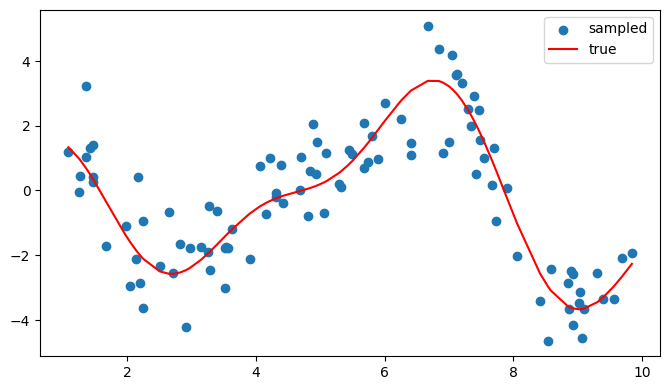

In [116]:
data = Linear_Regression.sampler(Linear_Regression.assignment_function, 100, 1, 10, random=True)
x = data.get("x")
y = data.get("y")

x_plot, y_plot = zip(*sorted(zip(x, y)))
x_plot = np.array(x_plot)
y_plot = np.array(y_plot)

plt.figure(figsize=(8, 4.5))
plt.scatter(x_plot, y_plot, label="sampled")
plt.plot(x_plot, Linear_Regression.assignment_function(x_plot), label="true", color='red')
plt.legend()
plt.show()

Section 1.2/1.3: Fitting with various amounts of basis functions

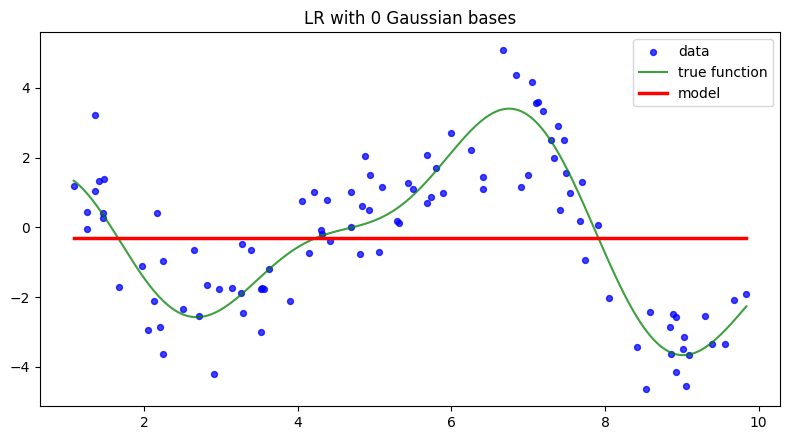

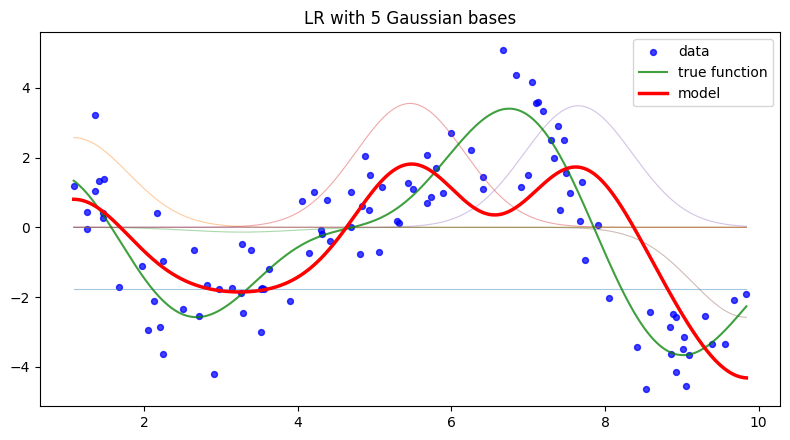

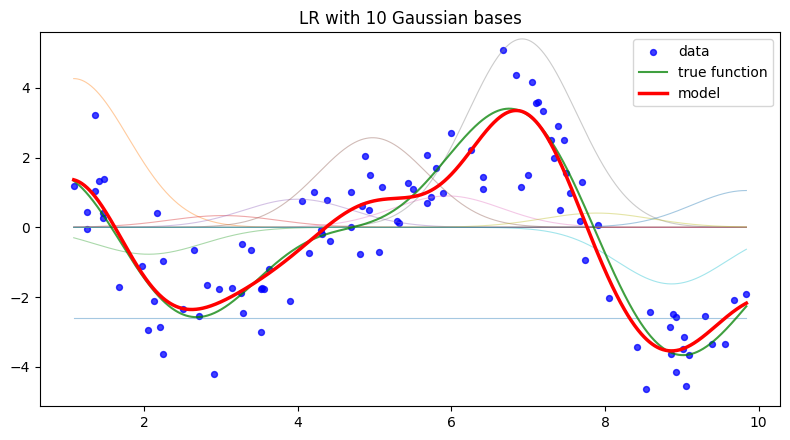

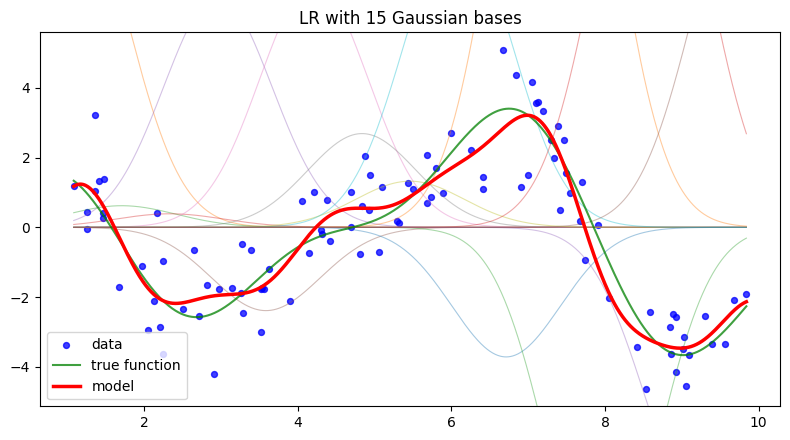

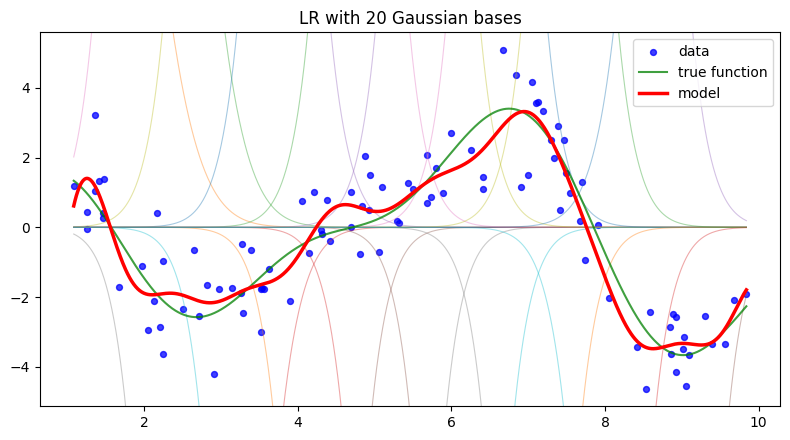

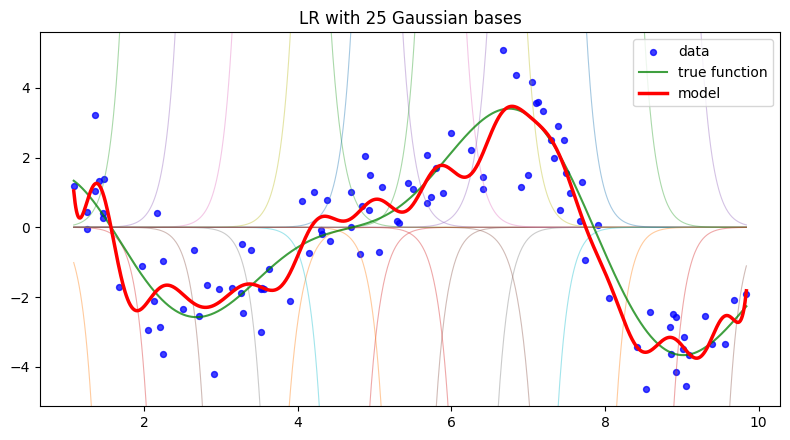

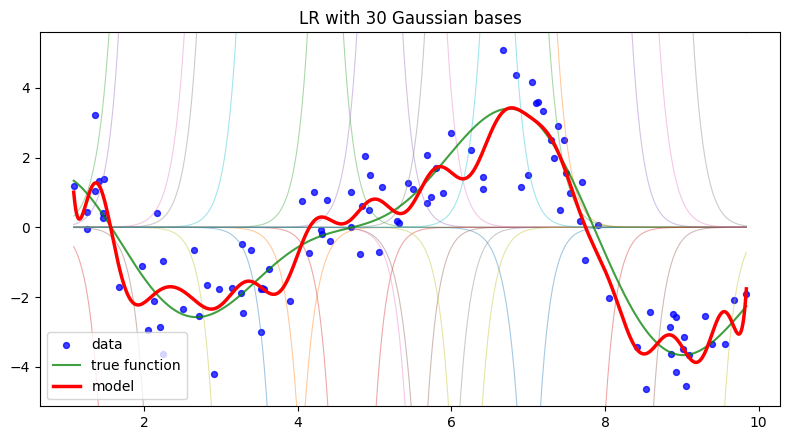

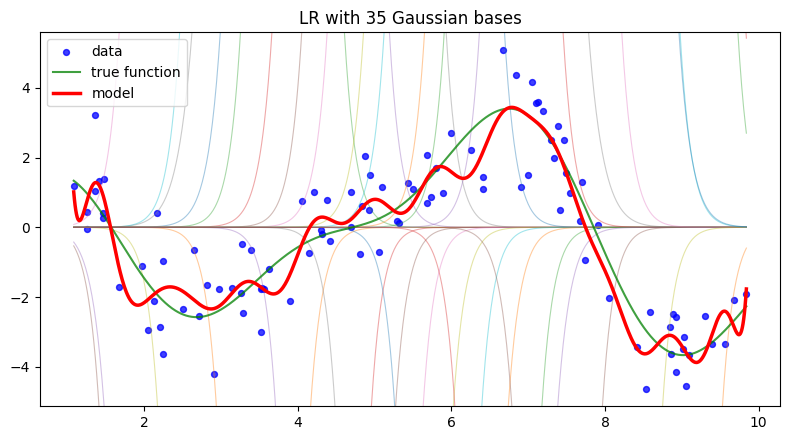

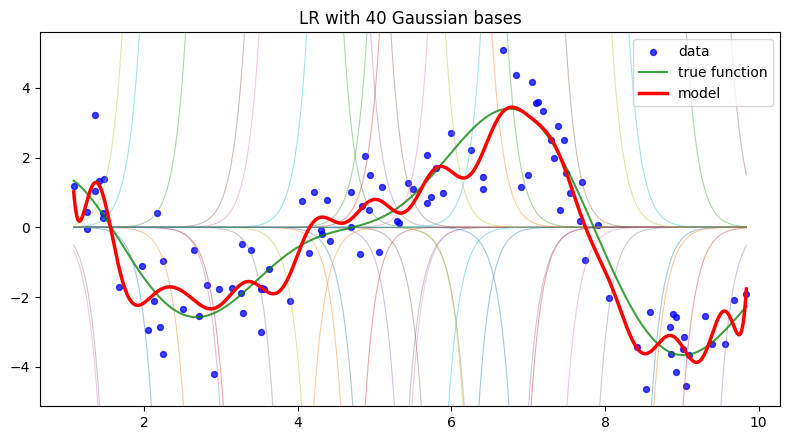

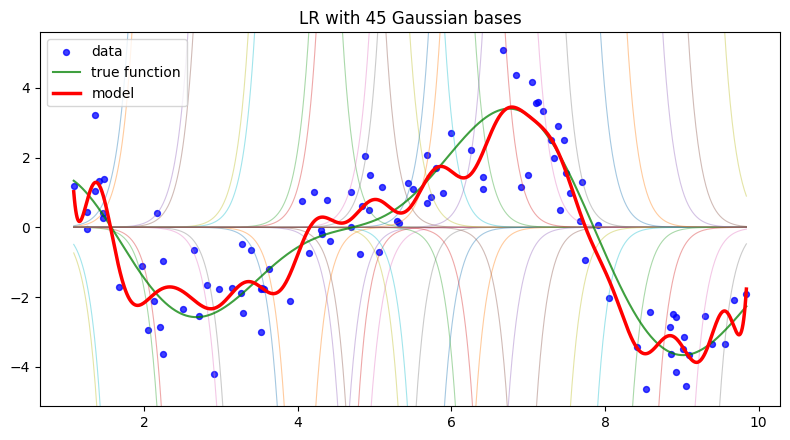

In [117]:
for i in range(10):
    model = Linear_Regression(x, y, num_features=i*5, basis_function=BasisFunctions.GAUSSIAN)
    model.fit(GDMethods.ANALYTIC)
    model.plot_model(x, y, show_bases=True, show_true_function=True, true_function=Linear_Regression.assignment_function, title=f"LR with {i*5} Gaussian bases")

Section 1.4: 10-fold Cross-Validation for #basis selection

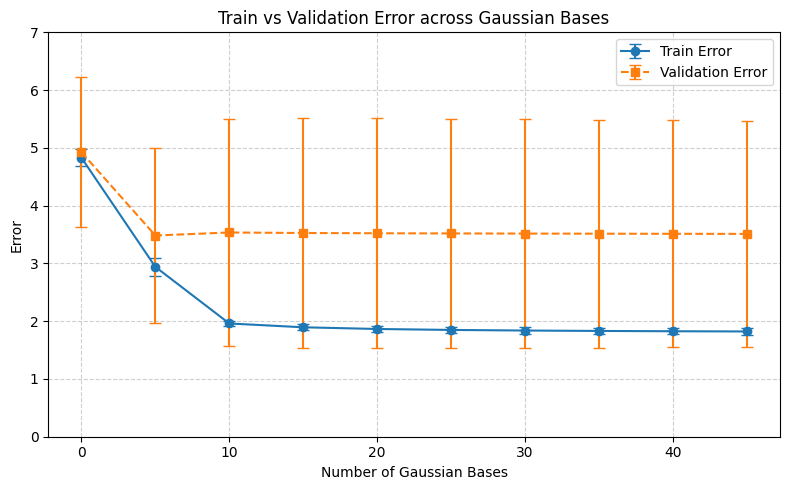

In [136]:
train_results, val_results = Linear_Regression.cross_validation_10_fold(x, y)

bases = [int(k.split()[0]) for k in train_results.keys()]
train_err = [v["train_err"] for v in train_results.values()]
train_std = [v["std"] for v in train_results.values()]
val_err = [v["val_err"] for v in val_results.values()]
val_std = [v["std"] for v in val_results.values()]

plt.figure(figsize=(8,5))

plt.errorbar(
    bases, train_err, yerr=train_std,
    fmt='o-', capsize=4, label='Train Error', color='tab:blue'
)
plt.errorbar(
    bases, val_err, yerr=val_std,
    fmt='s--', capsize=4, label='Validation Error', color='tab:orange'
)

plt.title("Train vs Validation Error across Gaussian Bases")
plt.xlabel("Number of Gaussian Bases")
plt.ylabel("Error")
plt.ylim(0, 7)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

We can see that 5 is the optimal number of Gaussian bases, even if 10 has the lowest Validation Error. This is because the validation error for 5 bases fits within 1 std of 10 bases' validation error and it is a "simpler" model than the one with 10 bases.
On another note, we can observe the transition from underfitting to overfitting by strictly looking at the validation curve. We can see that the model improves in validation error as you increase the number of bases from 0 to 10, which is also around which you observe underfitting (as the model can get better still), but starts to increase from there. This indicates that from 10 Gaussian bases, the model suffers from too much variance, thus hurting its validation performance, even if the training error consistently decreases.

Section 2.1: Regenerating data

In [137]:
generated_repetitions = []
for i in range(10):
    generated_repetitions.append(Linear_Regression.sampler(Linear_Regression.assignment_function, 100, 1, 10, random=True))

Section 2.2/2.3/2.4: Plotting fitted models and observing the Bias-Variance tradeoff

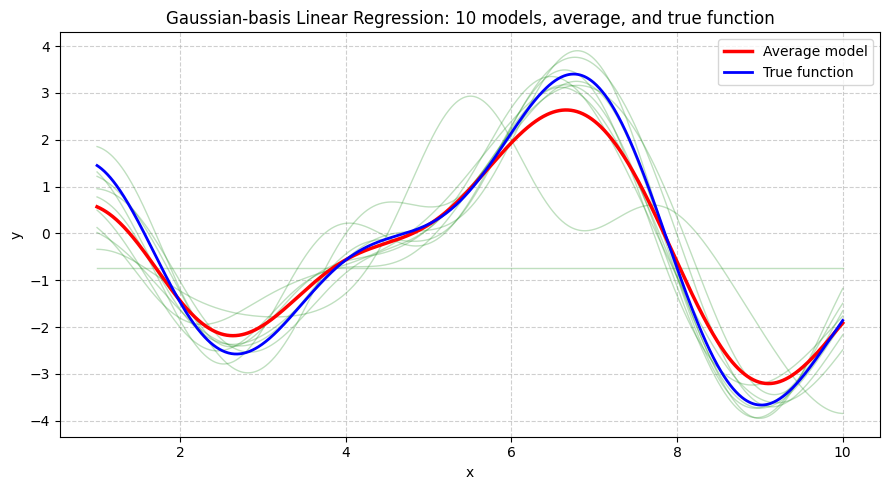

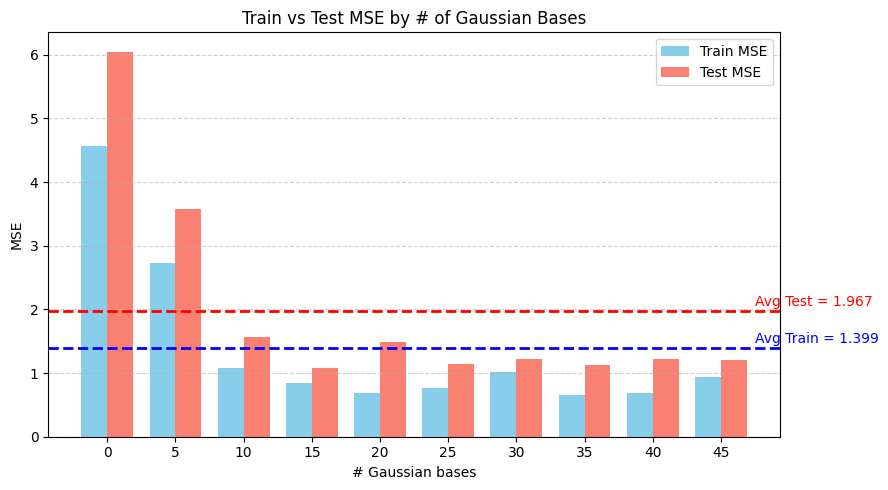

In [139]:
models = []
for i in range(10):
    dataset = generated_repetitions[i]
    x = dataset.get("x")
    y = dataset.get("y")
    
    model = Linear_Regression(x, y, num_features=i * 5, basis_function=BasisFunctions.GAUSSIAN)
    model.fit(GDMethods.GD, epoch=50000, learning_rate=0.001)
    models.append(model)

# domain for plotting
xmin, xmax = 1, 10
x = np.linspace(xmin, xmax, 1000)

# true function
true_vals = Linear_Regression.assignment_function(x)

# predictions
preds = [model.transform_X(x) @ model.weights for model in models] # plot individual models
preds = np.vstack(preds) 
avg_pred = preds.mean(axis=0) # E(f^_D(x))

plt.figure(figsize=(9,5))

# all models: thin, transparent green
for yhat in preds:
    plt.plot(x, yhat, linewidth=1, alpha=0.25, color='green')

# average: red
plt.plot(x, avg_pred, linewidth=2.5, color='red', label='Average model')

# true: blue dashed
plt.plot(x, true_vals, linewidth=2, color='blue', label='True function')

plt.legend(loc='best')

plt.title('Gaussian-basis Linear Regression: 10 models, average, and true function')
plt.xlabel('x'); plt.ylabel('y')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

test_dataset = Linear_Regression.sampler(Linear_Regression.assignment_function, 50, 1, 10, random=True)
errors = []
for i in range(10):
    model = models[i]
    transformed_X_test = model.transform_X(test_dataset.get("x"))
    y_test = test_dataset.get("y")
    errors.append(model.train_test_errors({ "x": model.X, "y": model.y }, { "x": transformed_X_test, "y": y_test }))

basis_counts = [i * 5 for i in range(10)]
train_mse = [e["train_err"] for e in errors]
test_mse  = [e["test_err"]  for e in errors]

# compute averages
avg_train = np.mean(train_mse)
avg_test  = np.mean(test_mse)

x = np.arange(len(basis_counts))
w = 0.38

fig, ax = plt.subplots(figsize=(9, 5))
ax.bar(x - w/2, train_mse, width=w, label='Train MSE', color='skyblue')
ax.bar(x + w/2, test_mse,  width=w, label='Test MSE', color='salmon')

# Add average lines
ax.axhline(avg_train, color='blue', linestyle='--', linewidth=2)
ax.axhline(avg_test,  color='red', linestyle='--', linewidth=2)

# Add text annotations near lines
ax.text(len(basis_counts)-0.5, avg_train*1.02,
        f'Avg Train = {avg_train:.3f}', color='blue', fontsize=10, va='bottom')
ax.text(len(basis_counts)-0.5, avg_test*1.02,
        f'Avg Test = {avg_test:.3f}', color='red', fontsize=10, va='bottom')

# Labels & grid
ax.set_xticks(x)
ax.set_xticklabels(basis_counts)
ax.set_xlabel('# Gaussian bases')
ax.set_ylabel('MSE')
ax.set_title('Train vs Test MSE by # of Gaussian Bases')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


We can observe the bias-variance tradeoff clearly by looking at how the test error behaves as we increase the number of Gaussian bases. As we start at 0, 5, we expect a larger test error due to the simplicity of the model acting against it. This is where high bias occurs (i.e. the error is mainly driven by the fact that the average model that is too simple is just too far away from the true function). As we increase the number of bases, we see that the test error decreases quickly, until about a minimum, where we can understand that the model fits the data as perfectly as possible. This is where the bias-variance tradeoff hits a sweet spot. Beyond the minimum, we expect the test error to increase again due to the model being too expressive - it has too much variance (i.e. the average of the distance between each model and the average of the models is large).

We can therefore conclude that, as the number of gaussian bases increases, we go from high bias/low variance to low bias/high variance.

In [146]:
#TASK 3
# 3.1 and 3.2

class Regularized_Linear_Regression(Linear_Regression):
    def __init__(self, X, y, num_features, basis_function: BasisFunctions, reg_type='L2', lam=0.0):
        super().__init__(X, y, num_features, basis_function)
        self.reg_type = reg_type
        self.lam = lam

def cross_validate_regularization(X, y, num_features, basis_function, reg_type="L2", lam_values=None, max_iter=1000, lr=0.01):
    """
    Perform 10-fold CV for a range of regularization strengths.
    
    Args:
        X, y: data
        reg_type: 'L1' or 'L2'
        lam_values: list of lambda values to test
        max_iter: for L1 gradient descent
        lr: learning rate for L1
    Returns:
        dict of mean train and val MSE for each lambda
    """
    if lam_values is None:
        lam_values = [0.001, 0.01, 0.1, 1, 10, 100]

    n = X.shape[0]
    folds = np.array_split(np.arange(n), 10)
    results = {}

    for lam in lam_values:
        train_mse = []
        val_mse = []

        for i in range(10):
            val_idx = folds[i]
            train_idx = np.hstack([folds[j] for j in range(10) if j != i])

            X_train, y_train = X[train_idx], y[train_idx]
            X_val, y_val = X[val_idx], y[val_idx]

            model = Regularized_Linear_Regression(
                X_train, y_train, 
                num_features=num_features, 
                basis_function=basis_function,
                reg_type=reg_type, 
                lam=lam
            )
            train_err = model.fit(GDMethods.GD, epoch=max_iter, learning_rate=lr, regularization=reg_type, regularization_strength=lam, output_err=True)

            y_val_pred = model.transform_X(X_val) @ model.weights

            train_mse.append(np.mean(train_err["train_errs"]))
            val_mse.append(np.mean((y_val - y_val_pred)**2))

        results[lam] = {
            "train_mse": np.mean(train_mse),
            "train_std": np.std(train_mse),
            "val_mse": np.mean(val_mse),
            "test_std": np.std(test_mse)
        }

    return results

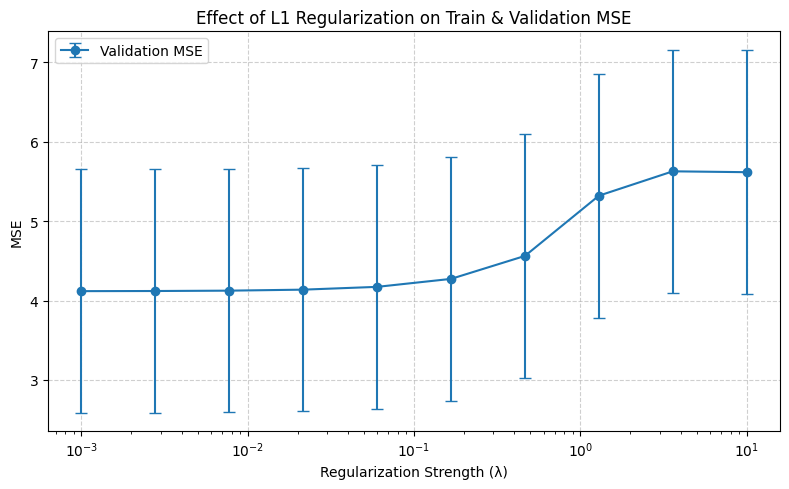

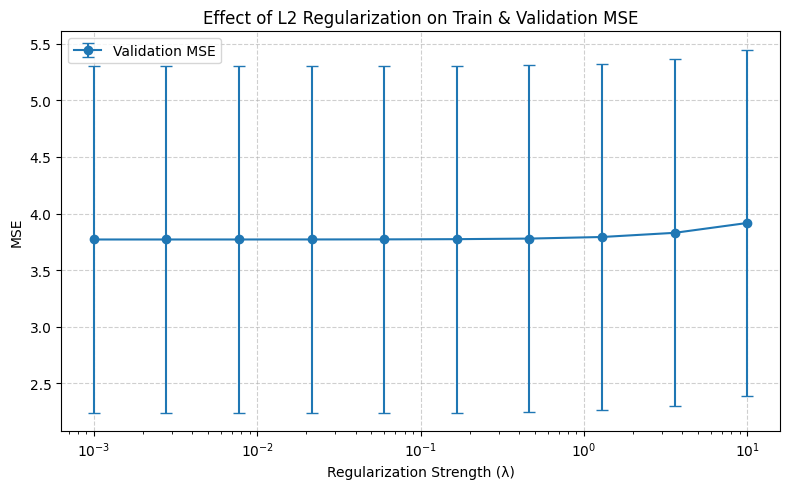

In [150]:
# 3.3
# ----- TASK 3.1 & 3.2 -----
# Plotting Train and Validation Errors vs λ for L1 and L2 regularization


# --- Hyperparams ---
lam_values = np.logspace(-3, 1, 10)
num_datasets = 50
sample_size = 100
x_start, x_end = 1, 10
D = 45                  # number of Gaussian bases
max_iter = 70         # for L1 gradient descent
lr = 1e-3               # learning rate for L1
basis = BasisFunctions.GAUSSIAN

# --- Main sweep ---
for reg_type in ["L1", "L2"]:
    train_means, val_means = [], []
    train_stds, val_stds = [], []

    # List aggregates train and val errors across all "num_datasets" datasets.
    errors = []

    for dataset_id in range(num_datasets):
        # dataset creation
        data = Linear_Regression.sampler(
            Linear_Regression.assignment_function,
            sample_size,
            x_start,
            x_end,
            random=True
        )
        x = data.get("x").reshape(-1)
        y = data.get("y").reshape(-1)

        # cross-validate for current lambda
        results = cross_validate_regularization(
            x, y, D, basis,
            reg_type=reg_type,
            lam_values=lam_values,
            max_iter=max_iter,
            lr=lr
        )

        errors.append(results)

    # Extract keys and values
    lambdas = np.array(list(results.keys()))
    train_mse = np.array([results[l]["train_mse"] for l in lambdas])
    train_std = np.array([results[l]["train_std"] for l in lambdas])
    val_mse   = np.array([results[l]["val_mse"]   for l in lambdas])
    val_std   = np.array([results[l]["test_std"]  for l in lambdas])  # assuming this is meant to be val_std/test_std

    # Sort by lambda (optional but helps for smooth plots)
    idx = np.argsort(lambdas)
    lambdas = lambdas[idx]
    train_mse, train_std = train_mse[idx], train_std[idx]
    val_mse, val_std = val_mse[idx], val_std[idx]

    # Plot
    plt.figure(figsize=(8,5))
    # plt.errorbar(lambdas, train_mse, yerr=train_std, fmt='-o', capsize=4, label='Train MSE')
    plt.errorbar(lambdas, val_mse,   yerr=val_std,   fmt='-o', capsize=4, label='Validation MSE')

    plt.xscale('log')
    plt.xlabel('Regularization Strength (λ)')
    plt.ylabel('MSE')
    plt.title(f"Effect of {reg_type} Regularization on Train & Validation MSE")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


Plotting Bias-Variance Decomposition for L2 Regularization...
Processing lambda = 0.001000 for L2 regularization
Processing lambda = 0.001833 for L2 regularization
Processing lambda = 0.003360 for L2 regularization
Processing lambda = 0.006158 for L2 regularization
Processing lambda = 0.011288 for L2 regularization
Processing lambda = 0.020691 for L2 regularization
Processing lambda = 0.037927 for L2 regularization
Processing lambda = 0.069519 for L2 regularization
Processing lambda = 0.127427 for L2 regularization
Processing lambda = 0.233572 for L2 regularization
Processing lambda = 0.428133 for L2 regularization
Processing lambda = 0.784760 for L2 regularization
Processing lambda = 1.438450 for L2 regularization
Processing lambda = 2.636651 for L2 regularization
Processing lambda = 4.832930 for L2 regularization
Processing lambda = 8.858668 for L2 regularization
Processing lambda = 16.237767 for L2 regularization
Processing lambda = 29.763514 for L2 regularization
Processing lambda 

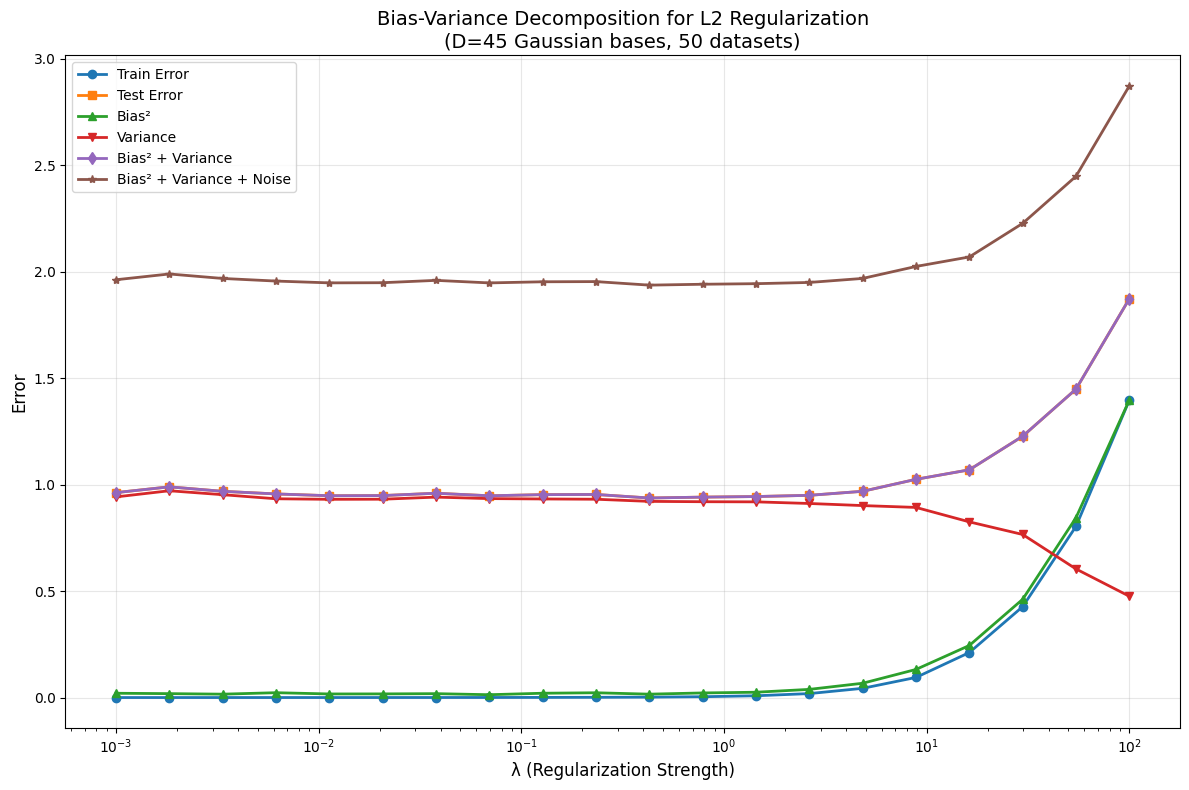


Plotting Bias-Variance Decomposition for L1 Regularization...
Processing lambda = 0.001000 for L1 regularization
Processing lambda = 0.001833 for L1 regularization
Processing lambda = 0.003360 for L1 regularization
Processing lambda = 0.006158 for L1 regularization
Processing lambda = 0.011288 for L1 regularization
Processing lambda = 0.020691 for L1 regularization
Processing lambda = 0.037927 for L1 regularization
Processing lambda = 0.069519 for L1 regularization
Processing lambda = 0.127427 for L1 regularization
Processing lambda = 0.233572 for L1 regularization
Processing lambda = 0.428133 for L1 regularization
Processing lambda = 0.784760 for L1 regularization
Processing lambda = 1.438450 for L1 regularization
Processing lambda = 2.636651 for L1 regularization
Processing lambda = 4.832930 for L1 regularization
Processing lambda = 8.858668 for L1 regularization
Processing lambda = 16.237767 for L1 regularization
Processing lambda = 29.763514 for L1 regularization
Processing lambda

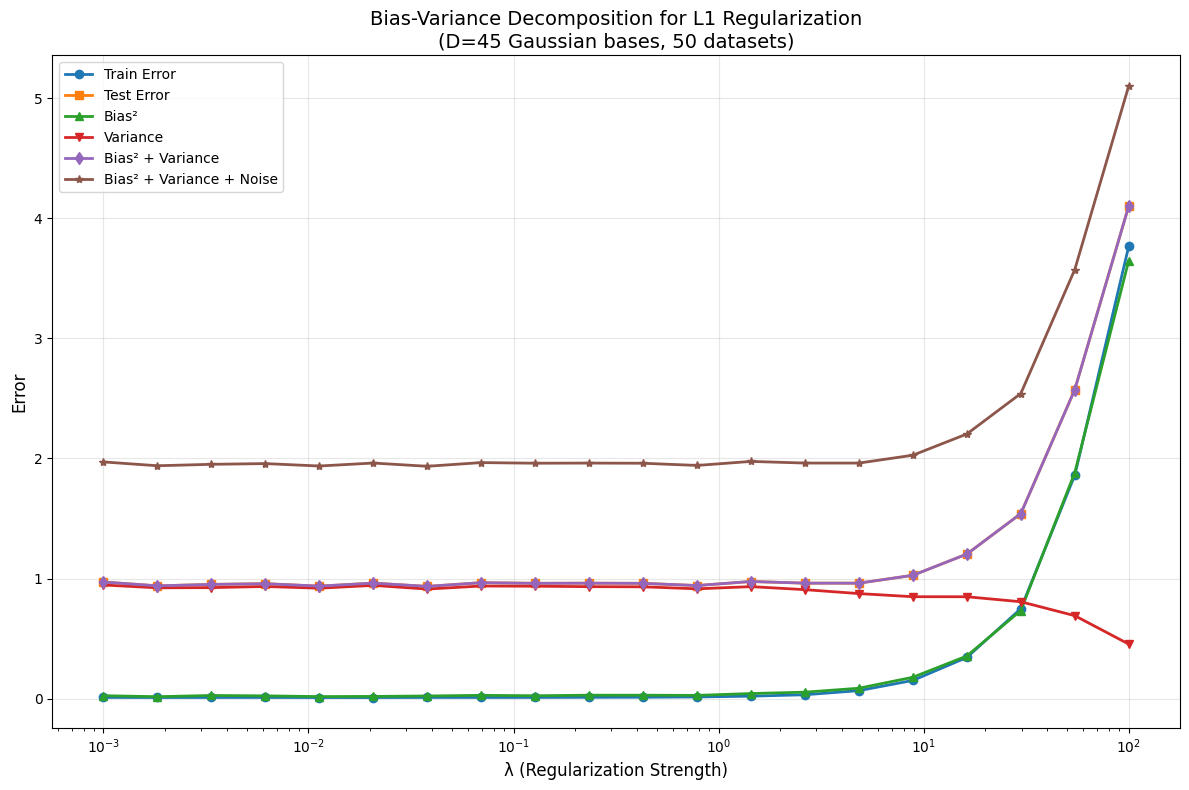

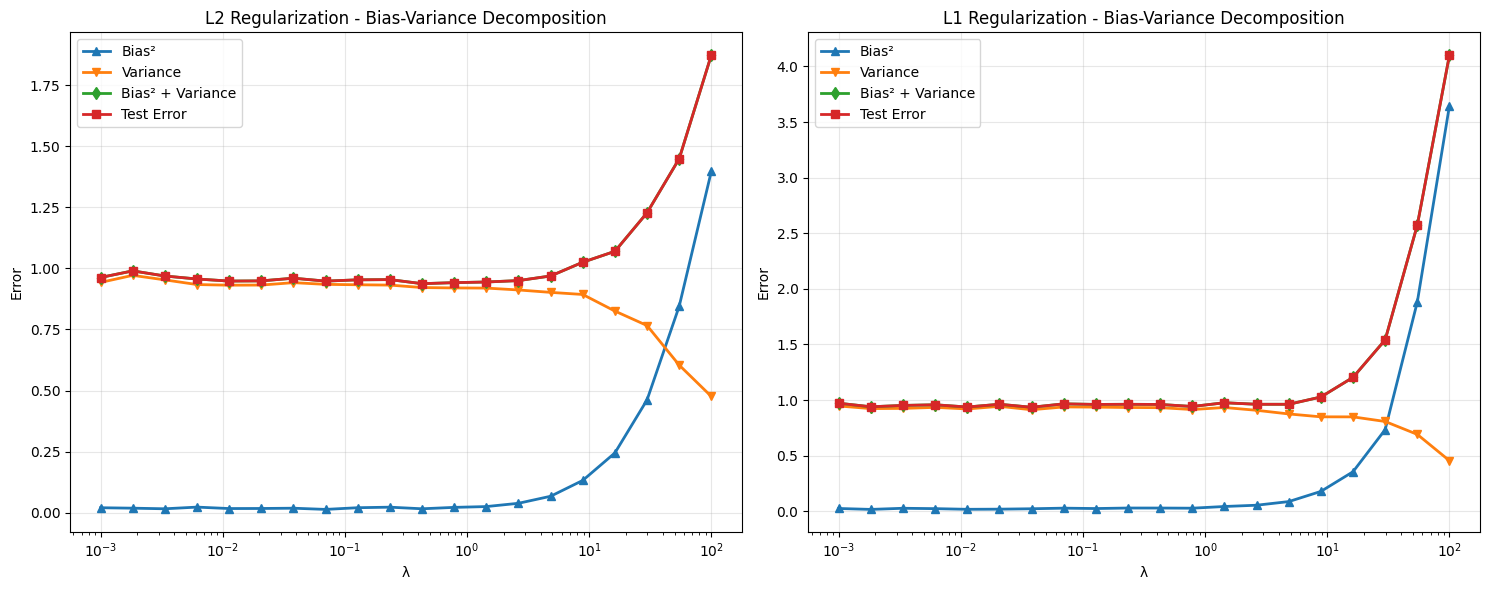

In [151]:
from enum import Enum

class BiasVarianceAnalyzer:
    """
    bias and variance analyzer class
    """
    def __init__(self, true_function, noise_std=1.0):
        self.true_function = true_function
        self.noise_std = noise_std
        self.noise_variance = noise_std ** 2
    
    def calculate_bias_variance_decomposition(self, X_test, y_test_true, predictions_list):
        """
        calculate bias^2, variance, and total error components
        
        Args:
            X_test: Test features
            y_test_true: True function values (without noise)
            predictions_list: List of predictions from different trained models
            
        Returns:
            Dictionary with bias^2, variance, and error components
        """
        # convert to arrays
        predictions_array = np.array(predictions_list)  # shape: (n_models, n_test_points)
        
        # obtain mean accross models
        y_pred_mean = np.mean(predictions_array, axis=0)
        
        # obtain bias squared for models
        bias_squared = np.mean((y_pred_mean - y_test_true) ** 2)
        
        # obtain variances for models
        variance = np.mean(np.var(predictions_array, axis=0))
        
        # total expected error = bias^2 + variance + noise_variance
        total_expected_error = bias_squared + variance + self.noise_variance
        
        return {
            'bias_squared': bias_squared,
            'variance': variance,
            'noise_variance': self.noise_variance,
            'bias_squared_plus_variance': bias_squared + variance,
            'total_expected_error': total_expected_error
        }

def plot_bias_variance_decomposition(reg_type, lam_values, num_datasets=50, 
                                   sample_size=100, x_start=1, x_end=10,
                                   D=45, max_iter=1000, lr=1e-3):
    """
    plot bias-variance decomposition for L1 or L2 regularization
    
    Args:
        reg_type: "L1" or "L2"
        lam_values: array of lambda values to test
        num_datasets: number of datasets to generate
        sample_size: size of each dataset
        x_start, x_end: range for x values
        D: number of Gaussian basis functions
        max_iter: maximum iterations for optimization
        lr: learning rate
    """
    
    # initialize analyzer
    analyzer = BiasVarianceAnalyzer(Linear_Regression.assignment_function, noise_std=1.0)
    
    # fixed test set for evaluation
    x_test = np.linspace(x_start, x_end, 1000)
    y_test_true = Linear_Regression.assignment_function(x_test)
    
    # storage for results
    results = {
        'train_errors': [],
        'test_errors': [],
        'bias_squared': [],
        'variance': [],
        'bias_variance_sum': [],
        'total_expected_error': []
    }
    
    for lam in lam_values:
        print(f"Processing lambda = {lam:.6f} for {reg_type} regularization")
        
        train_errors = []
        test_errors = []
        all_predictions = []
        
        for ds_idx in range(num_datasets):
            # training dataset
            data = Linear_Regression.sampler(
                Linear_Regression.assignment_function,
                sample_size,
                x_start,
                x_end,
                std=1.0,
                seed=ds_idx,
                random=True
            )
            x_train = data.get("x").reshape(-1, 1)
            y_train = data.get("y").reshape(-1, 1)
            
            # make design matrix with Gaussian bases
            base_model = Linear_Regression(x_train, y_train, num_features=D, 
                                         basis_function=BasisFunctions.GAUSSIAN)
            Phi_train = base_model.X
            
            # transform test set using the same basis functions
            Phi_test = base_model.transform_X(x_test)
            
            # train model with regularization
            if reg_type == "L2":
                # ridge regression analytic solution
                I = np.eye(Phi_train.shape[1])
                # Add small value to diagonal for numerical stability
                w = np.linalg.pinv(Phi_train.T @ Phi_train + lam * I) @ Phi_train.T @ y_train
                
                # Store weights in the model
                base_model.weights = w.flatten()
                
            elif reg_type == "L1":
                # lasso with grad descent
                w = np.zeros((Phi_train.shape[1], 1))
                for _ in range(max_iter):
                    # grad with L1 regularization
                    grad = -2 * Phi_train.T @ (y_train - Phi_train @ w) + lam * np.sign(w)
                    w -= lr * grad
                
                base_model.weights = w.flatten()
            
            # predictions
            y_train_pred = Phi_train @ base_model.weights.reshape(-1, 1)
            y_test_pred = Phi_test @ base_model.weights.reshape(-1, 1)
            
            # get errors
            train_error = np.mean((y_train - y_train_pred) ** 2)
            test_error = np.mean((y_test_true.reshape(-1, 1) - y_test_pred) ** 2)
            
            train_errors.append(train_error)
            test_errors.append(test_error)
            all_predictions.append(y_test_pred.flatten())
        
        # obtain bias-variance decomposition
        bv_results = analyzer.calculate_bias_variance_decomposition(
            x_test, y_test_true, all_predictions
        )
        
        #Store average results for this lambda
        results['train_errors'].append(np.mean(train_errors))
        results['test_errors'].append(np.mean(test_errors))
        results['bias_squared'].append(bv_results['bias_squared'])
        results['variance'].append(bv_results['variance'])
        results['bias_variance_sum'].append(bv_results['bias_squared_plus_variance'])
        results['total_expected_error'].append(bv_results['total_expected_error'])
    
    #plot
    plt.figure(figsize=(12, 8))
    
    plt.semilogx(lam_values, results['train_errors'], 'o-', label='Train Error', linewidth=2, markersize=6)
    plt.semilogx(lam_values, results['test_errors'], 's-', label='Test Error', linewidth=2, markersize=6)
    plt.semilogx(lam_values, results['bias_squared'], '^-', label='Bias²', linewidth=2, markersize=6)
    plt.semilogx(lam_values, results['variance'], 'v-', label='Variance', linewidth=2, markersize=6)
    plt.semilogx(lam_values, results['bias_variance_sum'], 'd-', 
                label='Bias² + Variance', linewidth=2, markersize=6)
    plt.semilogx(lam_values, results['total_expected_error'], '*-', 
                label='Bias² + Variance + Noise', linewidth=2, markersize=6)
    
    plt.xlabel('λ (Regularization Strength)', fontsize=12)
    plt.ylabel('Error', fontsize=12)
    plt.title(f'Bias-Variance Decomposition for {reg_type} Regularization\n'
             f'(D={D} Gaussian bases, {num_datasets} datasets)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()
    
    return results

# analysis for both
lam_values = np.logspace(-3, 2, 20)  # range

print("Plotting Bias-Variance Decomposition for L2 Regularization...")
results_l2 = plot_bias_variance_decomposition("L2", lam_values)

print("\nPlotting Bias-Variance Decomposition for L1 Regularization...")
results_l1 = plot_bias_variance_decomposition("L1", lam_values, lr=1e-4)  #smaller LR for L1 stability

# Comparative plot
plt.figure(figsize=(15, 6))

# L2 results
plt.subplot(1, 2, 1)
plt.semilogx(lam_values, results_l2['bias_squared'], '^-', label='Bias²', linewidth=2)
plt.semilogx(lam_values, results_l2['variance'], 'v-', label='Variance', linewidth=2)
plt.semilogx(lam_values, results_l2['bias_variance_sum'], 'd-', label='Bias² + Variance', linewidth=2)
plt.semilogx(lam_values, results_l2['test_errors'], 's-', label='Test Error', linewidth=2)
plt.xlabel('λ')
plt.ylabel('Error')
plt.title('L2 Regularization - Bias-Variance Decomposition')
plt.grid(True, alpha=0.3)
plt.legend()

# L1 results
plt.subplot(1, 2, 2)
plt.semilogx(lam_values, results_l1['bias_squared'], '^-', label='Bias²', linewidth=2)
plt.semilogx(lam_values, results_l1['variance'], 'v-', label='Variance', linewidth=2)
plt.semilogx(lam_values, results_l1['bias_variance_sum'], 'd-', label='Bias² + Variance', linewidth=2)
plt.semilogx(lam_values, results_l1['test_errors'], 's-', label='Test Error', linewidth=2)
plt.xlabel('λ')
plt.ylabel('Error')
plt.title('L1 Regularization - Bias-Variance Decomposition')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

Section 4.1: Generating data

In [194]:
data = Linear_Regression.sampler(Linear_Regression.assignment_function_section_4, 30, 0, 10, random=True, section_4=True)
x = data.get("x")
y = data.get("y")

lambdas = np.logspace(-3, 1, 10)
results = { "L1": {}, "L2": {}}
models = { "L1": {}, "L2": {}}

for reg_type in ["L1", "L2"]:
    for lambdaa in lambdas:
        model = Linear_Regression(x, y, num_features=1, basis_function=BasisFunctions.LINEAR)
        weights = model.fit(GDMethods.GD, epoch=100, learning_rate=0.002, regularization=reg_type, regularization_strength=lambdaa, output_weights=True)

        results[reg_type][lambdaa] = weights
        models[reg_type][lambdaa] = model

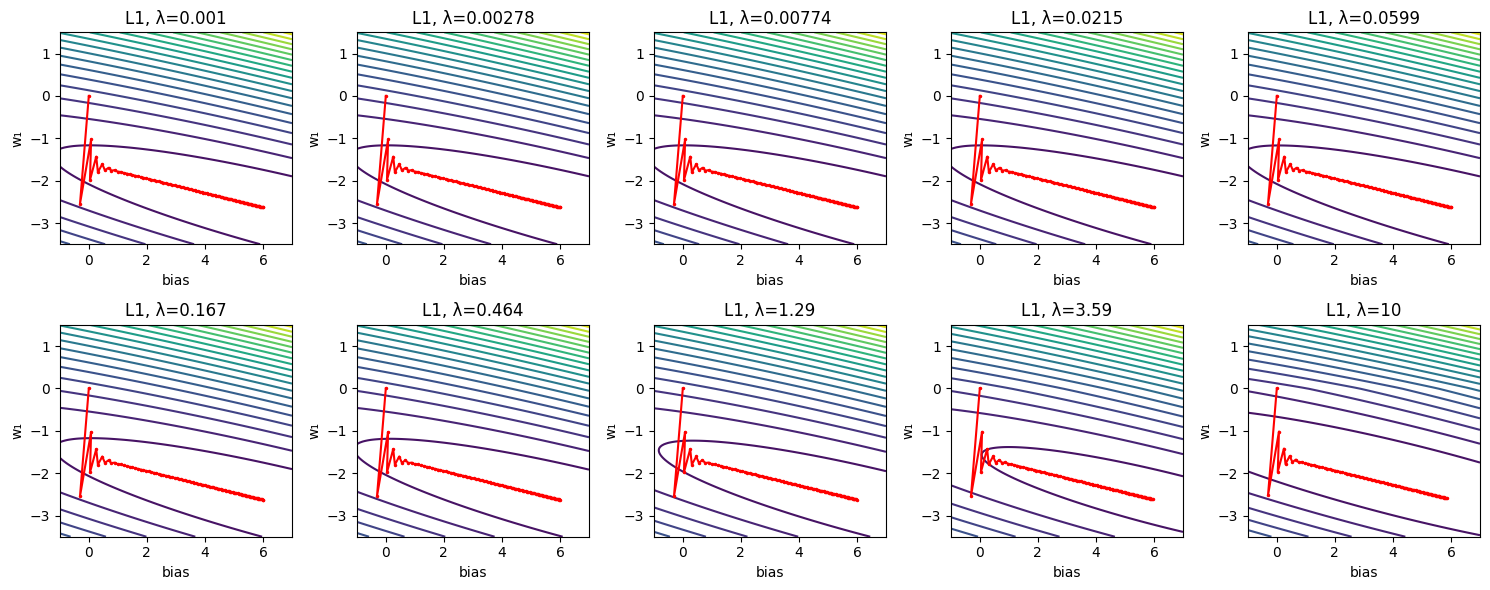

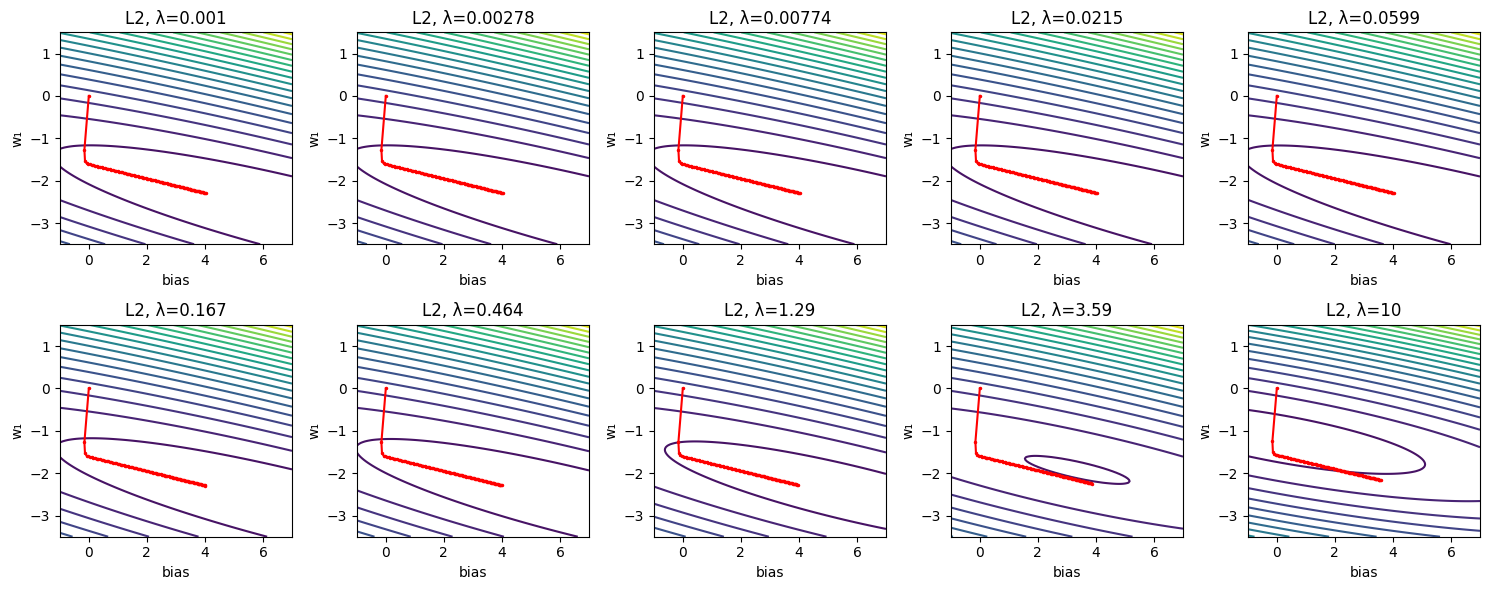

In [195]:
for reg_type in ["L1", "L2"]:
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    for i, lambdaa in enumerate(lambdas):
        ax = axes[i]
        weights_hist = np.array(results[reg_type][lambdaa]["weights"])
        b_hist, w_hist = weights_hist[:, 0], weights_hist[:, 1]

        # ---- Fixed global axis ranges ----
        b_vals = np.linspace(-1, 7, 150)      # bias range
        w_vals = np.linspace(-3.5, 1.5, 150)  # weight range

        B, W = np.meshgrid(b_vals, w_vals)
        Z = loss_surface(B, W, x, y, reg_type, lambdaa)

        cs = ax.contour(B, W, Z, levels=20, cmap='viridis')
        ax.plot(b_hist, w_hist, 'r.-', markersize=3)
        ax.set_xlim(-1, 7)
        ax.set_ylim(-3.5, 1.5)
        ax.set_title(f"{reg_type}, λ={lambdaa:.3g}")
        ax.set_xlabel("bias")
        ax.set_ylabel("w₁")

    plt.tight_layout()
    plt.show()